In [31]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [32]:
print(tf.__version__)

2.5.0


In [33]:
import pathlib
data_dir = pathlib.Path("camera_interface/img/")

In [34]:
len(list(data_dir.glob('*/*.png')))

2978

In [35]:
batch_size = 32
img_height = 180
img_width = 180

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2978 files belonging to 2 classes.
Using 2383 files for training.


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2978 files belonging to 2 classes.
Using 595 files for validation.


In [38]:
class_names = train_ds.class_names
print(class_names)

['0', '1']


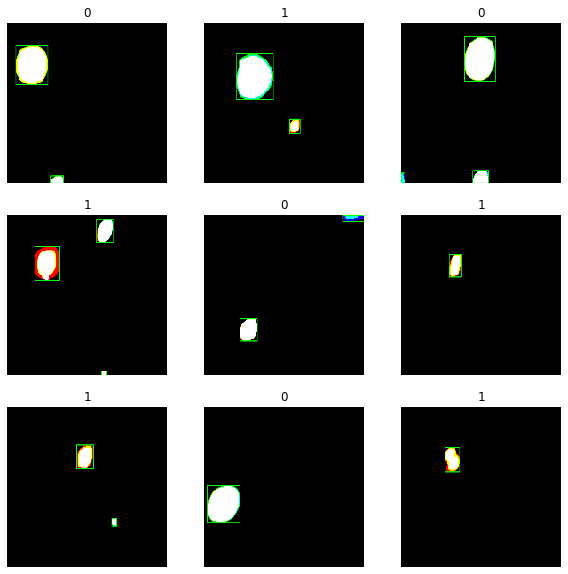

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [41]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [42]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [44]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [45]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [46]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)


Epoch 1/3
75/75 [==============================] - 46s 616ms/step - loss: 0.1894 - accuracy: 0.9362 - val_loss: 0.0516 - val_accuracy: 0.9798
Epoch 2/3
75/75 [==============================] - 51s 677ms/step - loss: 0.0449 - accuracy: 0.9870 - val_loss: 0.0500 - val_accuracy: 0.9815
Epoch 3/3
75/75 [==============================] - 51s 675ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.0389 - val_accuracy: 0.9899


In [61]:
model.save("model.h5")

In [57]:
model.predict(tf.reshape(images[0:3], (3, 180, 180, 3)))

array([[15.261213 , -8.4932   ],
       [-6.873396 ,  6.7214584],
       [ 6.144649 , -3.5079007]], dtype=float32)

In [53]:
images[0].shape

TensorShape([180, 180, 3])

In [55]:
tf.reshape(images[0], (1, 180, 180, 3)).shape

TensorShape([1, 180, 180, 3])

In [54]:
help(tf.reshape)

Help on function reshape in module tensorflow.python.ops.array_ops:

reshape(tensor, shape, name=None)
    Reshapes a tensor.
    
    Given `tensor`, this operation returns a new `tf.Tensor` that has the same
    values as `tensor` in the same order, except with a new shape given by
    `shape`.
    
    >>> t1 = [[1, 2, 3],
    ...       [4, 5, 6]]
    >>> print(tf.shape(t1).numpy())
    [2 3]
    >>> t2 = tf.reshape(t1, [6])
    >>> t2
    <tf.Tensor: shape=(6,), dtype=int32,
      numpy=array([1, 2, 3, 4, 5, 6], dtype=int32)>
    >>> tf.reshape(t2, [3, 2])
    <tf.Tensor: shape=(3, 2), dtype=int32, numpy=
      array([[1, 2],
             [3, 4],
             [5, 6]], dtype=int32)>
    
    The `tf.reshape` does not change the order of or the total number of elements
    in the tensor, and so it can reuse the underlying data buffer. This makes it
    a fast operation independent of how big of a tensor it is operating on.
    
    >>> tf.reshape([1, 2, 3], [2, 2])
    Traceback (mos

In [58]:
new_model = tf.keras.models.load_model('model')

In [59]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 32)       

In [60]:
new_model.predict(tf.reshape(images[0], (1, 180, 180, 3)))

array([[15.261215, -8.493198]], dtype=float32)